In [303]:
import tensorflow as tf
import os
import tensorflow.keras as keras
import cv2
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.xception import Xception,preprocess_input
from keras.applications import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from warnings import filterwarnings
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


In [361]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
labels_binary = ['has_tumor','no_tumor']
num_classes = 4
image_size = 224
train_data_dir = "brain_tumor/Training"
validation_data_dir = "brain_tumor/Testing"

In [367]:
X_train_binary = []
y_train_binary = []
for i in labels:
    folderPath = os.path.join('brain_tumor','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train_binary.append(img)
        if i in ['glioma_tumor','meningioma_tumor','pituitary_tumor']: 
            y_train_binary.append('has_tumor')
        else:
            y_train_binary.append('no_tumor')
        
for i in labels:
    folderPath = os.path.join('brain_tumor','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train_binary.append(img)
        if i in ['glioma_tumor','meningioma_tumor','pituitary_tumor']: 
            y_train_binary.append('has_tumor')
        else:
            y_train_binary.append('no_tumor')
        
X_train_binary = np.array(X_train_binary)
y_train_binary = np.array(y_train_binary)

100%|██████████████████████████████████████████| 74/74 [00:00<00:00, 282.56it/s]


In [363]:
X_train = []
y_train = []
for i in labels:
    folderPath = os.path.join('brain_tumor','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('brain_tumor','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████████████████████████████████████| 74/74 [00:00<00:00, 261.14it/s]


In [364]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [368]:
X_train_binary, y_train_binary = shuffle(X_train_binary, y_train_binary, random_state=101)

In [365]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [369]:
X_train_binary,X_test_binary,y_train_binary,y_test_binary = train_test_split(X_train_binary,y_train_binary, test_size=0.1,random_state=101)

In [301]:
def generate_train_test(y, labels):
    new_set = []
    for i in y:
        new_set.append(labels.index(i))
    return new_set, tf.keras.utils.to_categorical(new_set)

In [366]:
y_train_new, y_train = generate_train_test(y_train, labels)
y_test_new, y_test = generate_train_test(y_test, labels)

In [370]:
y_train_binary_new, y_train_binary = generate_train_test(y_train_binary, ['has_tumor', 'no_tumor'])
y_test_binary_new, y_test_binary = generate_train_test(y_test_binary, ['has_tumor', 'no_tumor'])

In [190]:
# create the EfficientNetB0 pre-trained model
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))
# create the InceptionV3 pre-trained model
inception_v3 = InceptionV3(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))
# create the Xception pre-trained model
xception = Xception(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))
# create the ResNet50 pre-trained model
resnet50 = ResNet50(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))
# create the MobileNet pre-trained model
mobilenet = MobileNet(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [191]:
def generate_model(model):
    x = model.output
    # add a global spatial average pooling layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    # add a logistic layer for 4 classes
    x = tf.keras.layers.Dense(4,activation='softmax')(x)
    final_model = tf.keras.models.Model(inputs=model.input, outputs = x)
    return final_model
    

In [332]:
def generate_model_binary(model):
    x = model.output
    # add a global spatial average pooling layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    # add a logistic layer for 2 classes
    x = tf.keras.layers.Dense(2,activation='softmax')(x)
    final_model = tf.keras.models.Model(inputs=model.input, outputs = x)
    return final_model

In [192]:
effnet_model = generate_model(effnet)
inception_v3_model = generate_model(inception_v3)
xception_model = generate_model(xception)
resnet50_model = generate_model(resnet50)
mobilenet_model = generate_model(mobilenet)
# compile each model
for model in [effnet_model, inception_v3_model, xception_model, resnet50_model, mobilenet_model]:
    model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])


In [375]:
effnet_model_binary = generate_model_binary(effnet)
inception_v3_model_binary = generate_model_binary(inception_v3)
xception_model_binary = generate_model_binary(xception)
resnet50_model_binary = generate_model_binary(resnet50)
mobilenet_model_binary = generate_model_binary(mobilenet)
# compile each model
for model in [effnet_model_binary, inception_v3_model_binary, xception_model_binary, resnet50_model_binary, mobilenet_model_binary]:
    model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [266]:
effnet_model.summary()

Model: "model_46"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_6 (Rescaling)         (None, 224, 224, 3)  0           input_28[0][0]                   
__________________________________________________________________________________________________
normalization_6 (Normalization) (None, 224, 224, 3)  7           rescaling_6[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_6[0][0]            
___________________________________________________________________________________________

In [267]:
inception_v3_model.summary()

Model: "model_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_768 (Conv2D)             (None, 111, 111, 32) 864         input_29[0][0]                   
__________________________________________________________________________________________________
batch_normalization_768 (BatchN (None, 111, 111, 32) 96          conv2d_768[0][0]                 
__________________________________________________________________________________________________
activation_752 (Activation)     (None, 111, 111, 32) 0           batch_normalization_768[0][0]    
___________________________________________________________________________________________

In [268]:
xception_model.summary()

Model: "model_48"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_30[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [269]:
resnet50_model.summary()

Model: "model_49"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_31[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [270]:
mobilenet_model.summary()

Model: "model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0  

In [193]:
def genrate_history(name, model):
    tensorboard = TensorBoard(log_dir = 'logs')
    checkpoint = ModelCheckpoint(name+".h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                                  mode='auto',verbose=1)
    history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                       callbacks=[tensorboard,checkpoint,reduce_lr])
    return history
    

In [376]:
def genrate_history_binary(name, model):
    tensorboard = TensorBoard(log_dir = 'logs')
    checkpoint = ModelCheckpoint(name+"_binary"+".h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                                  mode='auto',verbose=1)
    history = model.fit(X_train_binary, y_train_binary,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                       callbacks=[tensorboard,checkpoint,reduce_lr])
    return history

In [377]:
start = time.time()
effnet_history_binary = genrate_history_binary("effnet_binary", effnet_model_binary)
end = time.time()
print(end - start)

2022-04-19 22:12:52.429078: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-19 22:12:52.429150: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-04-19 22:12:52.429304: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/12
 1/83 [..............................] - ETA: 6:51 - loss: 1.1622 - accuracy: 0.2500

2022-04-19 22:12:57.593656: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-19 22:12:57.593675: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 2/83 [..............................] - ETA: 2:28 - loss: 0.9675 - accuracy: 0.3984

2022-04-19 22:12:59.586258: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-04-19 22:12:59.597010: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-04-19 22:12:59.605053: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_04_19_22_12_59
2022-04-19 22:12:59.608770: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_19_22_12_59/Shuangs-MacBook-Pro.local.trace.json.gz
2022-04-19 22:12:59.623595: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_04_19_22_12_59
2022-04-19 22:12:59.623726: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2022_04_19_22_12_59/Shuangs-MacBook-Pro.local.memory_profile.json.gz
2022-

83/83 [==============================] - 155s 2s/step - loss: 0.1172 - accuracy: 0.9411 - val_loss: 0.0898 - val_accuracy: 0.9830

Epoch 00001: val_accuracy improved from -inf to 0.98299, saving model to effnet_binary_binary.h5
Epoch 2/12
83/83 [==============================] - 151s 2s/step - loss: 0.0322 - accuracy: 0.9886 - val_loss: 0.0766 - val_accuracy: 0.9864

Epoch 00002: val_accuracy improved from 0.98299 to 0.98639, saving model to effnet_binary_binary.h5
Epoch 3/12
83/83 [==============================] - 155s 2s/step - loss: 0.0222 - accuracy: 0.9899 - val_loss: 0.1159 - val_accuracy: 0.9660

Epoch 00003: val_accuracy did not improve from 0.98639
Epoch 4/12
83/83 [==============================] - 155s 2s/step - loss: 0.0208 - accuracy: 0.9936 - val_loss: 0.0782 - val_accuracy: 0.9864

Epoch 00004: val_accuracy did not improve from 0.98639

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/12
83/83 [==============================] - 155

In [380]:
start = time.time()
mobilenet_history_binary = genrate_history_binary("mobilenet_binary", mobilenet_model_binary)
end = time.time()
print(end - start)

2022-04-19 22:54:13.049134: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-19 22:54:13.049220: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-04-19 22:54:13.049387: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/12
 1/83 [..............................] - ETA: 3:17 - loss: 1.1362 - accuracy: 0.5000

2022-04-19 22:54:15.537641: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-19 22:54:15.537657: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 2/83 [..............................] - ETA: 1:52 - loss: 0.9069 - accuracy: 0.5938

2022-04-19 22:54:16.982170: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-04-19 22:54:16.986260: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-04-19 22:54:16.989281: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_04_19_22_54_16
2022-04-19 22:54:16.991635: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_19_22_54_16/Shuangs-MacBook-Pro.local.trace.json.gz
2022-04-19 22:54:16.997314: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_04_19_22_54_16
2022-04-19 22:54:16.997415: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2022_04_19_22_54_16/Shuangs-MacBook-Pro.local.memory_profile.json.gz
2022-

83/83 [==============================] - 118s 1s/step - loss: 0.1387 - accuracy: 0.9475 - val_loss: 1.0553 - val_accuracy: 0.7789

Epoch 00001: val_accuracy improved from -inf to 0.77891, saving model to mobilenet_binary_binary.h5
Epoch 2/12
83/83 [==============================] - 114s 1s/step - loss: 0.0698 - accuracy: 0.9762 - val_loss: 0.8333 - val_accuracy: 0.8503

Epoch 00002: val_accuracy improved from 0.77891 to 0.85034, saving model to mobilenet_binary_binary.h5
Epoch 3/12
83/83 [==============================] - 118s 1s/step - loss: 0.0074 - accuracy: 0.9969 - val_loss: 0.0524 - val_accuracy: 0.9932

Epoch 00003: val_accuracy improved from 0.85034 to 0.99320, saving model to mobilenet_binary_binary.h5
Epoch 4/12
83/83 [==============================] - 119s 1s/step - loss: 0.0106 - accuracy: 0.9960 - val_loss: 0.1134 - val_accuracy: 0.9796

Epoch 00004: val_accuracy did not improve from 0.99320
Epoch 5/12
83/83 [==============================] - 116s 1s/step - loss: 0.0013 - 

In [383]:
start = time.time()
inception_v3_history_binary = genrate_history_binary("inception_v3_binary", inception_v3_model_binary)
end = time.time()
print(end - start)

2022-04-19 23:44:15.844350: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-19 23:44:15.844417: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-04-19 23:44:15.844542: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/12
 1/83 [..............................] - ETA: 10:06 - loss: 0.9797 - accuracy: 0.4688

2022-04-19 23:44:23.381589: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-19 23:44:23.381613: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 2/83 [..............................] - ETA: 6:01 - loss: 0.7921 - accuracy: 0.5938 

2022-04-19 23:44:27.890905: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-04-19 23:44:27.901389: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-04-19 23:44:27.909099: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_04_19_23_44_27
2022-04-19 23:44:27.912635: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_19_23_44_27/Shuangs-MacBook-Pro.local.trace.json.gz
2022-04-19 23:44:27.925536: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_04_19_23_44_27
2022-04-19 23:44:27.925673: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2022_04_19_23_44_27/Shuangs-MacBook-Pro.local.memory_profile.json.gz
2022-

83/83 [==============================] - 383s 5s/step - loss: 0.1602 - accuracy: 0.9358 - val_loss: 70.5310 - val_accuracy: 0.8435

Epoch 00001: val_accuracy improved from -inf to 0.84354, saving model to inception_v3_binary_binary.h5
Epoch 2/12
83/83 [==============================] - 385s 5s/step - loss: 0.1032 - accuracy: 0.9600 - val_loss: 172.1557 - val_accuracy: 0.8469

Epoch 00002: val_accuracy improved from 0.84354 to 0.84694, saving model to inception_v3_binary_binary.h5
Epoch 3/12
83/83 [==============================] - 379s 5s/step - loss: 0.0606 - accuracy: 0.9798 - val_loss: 0.6663 - val_accuracy: 0.8878

Epoch 00003: val_accuracy improved from 0.84694 to 0.88776, saving model to inception_v3_binary_binary.h5
Epoch 4/12
83/83 [==============================] - 380s 5s/step - loss: 0.0583 - accuracy: 0.9820 - val_loss: 0.0602 - val_accuracy: 0.9864

Epoch 00004: val_accuracy improved from 0.88776 to 0.98639, saving model to inception_v3_binary_binary.h5
Epoch 5/12
83/83 [=

In [384]:
start = time.time()
xception_history_binary = genrate_history_binary("xception_binary", xception_model_binary)
end = time.time()
print(end - start)

Epoch 1/12


2022-04-20 00:59:53.398539: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-20 00:59:53.398555: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-04-20 00:59:53.398585: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


 1/83 [..............................] - ETA: 16:54 - loss: 0.9880 - accuracy: 0.2500

2022-04-20 01:00:05.846854: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-20 01:00:05.846873: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 2/83 [..............................] - ETA: 13:46 - loss: 0.8089 - accuracy: 0.4375

2022-04-20 01:00:16.091672: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-04-20 01:00:16.098516: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-04-20 01:00:16.103414: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_04_20_01_00_16
2022-04-20 01:00:16.105787: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_20_01_00_16/Shuangs-MacBook-Pro.local.trace.json.gz
2022-04-20 01:00:16.114558: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_04_20_01_00_16
2022-04-20 01:00:16.114664: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2022_04_20_01_00_16/Shuangs-MacBook-Pro.local.memory_profile.json.gz
2022-

83/83 [==============================] - 857s 10s/step - loss: 0.1131 - accuracy: 0.9464 - val_loss: 7.1807 - val_accuracy: 0.8639

Epoch 00001: val_accuracy improved from -inf to 0.86395, saving model to xception_binary_binary.h5
Epoch 2/12
83/83 [==============================] - 841s 10s/step - loss: 0.0557 - accuracy: 0.9812 - val_loss: 0.2679 - val_accuracy: 0.9592

Epoch 00002: val_accuracy improved from 0.86395 to 0.95918, saving model to xception_binary_binary.h5
Epoch 3/12
83/83 [==============================] - 814s 10s/step - loss: 0.0341 - accuracy: 0.9897 - val_loss: 0.2000 - val_accuracy: 0.9728

Epoch 00003: val_accuracy improved from 0.95918 to 0.97279, saving model to xception_binary_binary.h5
Epoch 4/12
83/83 [==============================] - 816s 10s/step - loss: 0.0156 - accuracy: 0.9957 - val_loss: 0.3535 - val_accuracy: 0.9490

Epoch 00004: val_accuracy did not improve from 0.97279
Epoch 5/12
83/83 [==============================] - 819s 10s/step - loss: 0.0296 

In [385]:
start = time.time()
resnet50_history_binary = genrate_history_binary("resnet50_binary", resnet50_model_binary)
end = time.time()
print(end - start)

Epoch 1/12


2022-04-20 03:44:23.892672: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-20 03:44:23.892686: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-04-20 03:44:23.892779: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


 1/83 [..............................] - ETA: 13:13 - loss: 0.5482 - accuracy: 0.6562

2022-04-20 03:44:33.649344: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-20 03:44:33.649369: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 2/83 [..............................] - ETA: 9:37 - loss: 0.4227 - accuracy: 0.7422 

2022-04-20 03:44:40.819551: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-04-20 03:44:40.828099: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-04-20 03:44:40.834136: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_04_20_03_44_40
2022-04-20 03:44:40.837114: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_20_03_44_40/Shuangs-MacBook-Pro.local.trace.json.gz
2022-04-20 03:44:40.847770: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_04_20_03_44_40
2022-04-20 03:44:40.847912: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2022_04_20_03_44_40/Shuangs-MacBook-Pro.local.memory_profile.json.gz
2022-

83/83 [==============================] - 607s 7s/step - loss: 0.1299 - accuracy: 0.9496 - val_loss: 173.5078 - val_accuracy: 0.8469

Epoch 00001: val_accuracy improved from -inf to 0.84694, saving model to resnet50_binary_binary.h5
Epoch 2/12
83/83 [==============================] - 604s 7s/step - loss: 0.0931 - accuracy: 0.9674 - val_loss: 2.9065 - val_accuracy: 0.8673

Epoch 00002: val_accuracy improved from 0.84694 to 0.86735, saving model to resnet50_binary_binary.h5
Epoch 3/12
83/83 [==============================] - 603s 7s/step - loss: 0.0449 - accuracy: 0.9867 - val_loss: 0.1729 - val_accuracy: 0.9184

Epoch 00003: val_accuracy improved from 0.86735 to 0.91837, saving model to resnet50_binary_binary.h5
Epoch 4/12
83/83 [==============================] - 603s 7s/step - loss: 0.0281 - accuracy: 0.9927 - val_loss: 2.2647 - val_accuracy: 0.6020

Epoch 00004: val_accuracy did not improve from 0.91837
Epoch 5/12
83/83 [==============================] - 603s 7s/step - loss: 0.0219 - a

In [360]:
print(X_train_binary.shape)
print(y_train_binary.shape)
print(effnet_model_binary)

(2937, 224, 224, 3)
(2937, 2)


In [194]:
effnet_history = genrate_history("effnet", effnet_model)

2022-04-17 01:16:22.737314: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-17 01:16:22.737342: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-04-17 01:16:22.737399: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/12
 1/83 [..............................] - ETA: 6:53 - loss: 1.7249 - accuracy: 0.0938

2022-04-17 01:16:28.202510: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-17 01:16:28.202530: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 2/83 [..............................] - ETA: 2:49 - loss: 1.6361 - accuracy: 0.1328

2022-04-17 01:16:30.029013: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-04-17 01:16:30.039958: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-04-17 01:16:30.047926: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_04_17_01_16_30
2022-04-17 01:16:30.051729: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_17_01_16_30/Shuangs-MacBook-Pro.local.trace.json.gz
2022-04-17 01:16:30.066088: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_04_17_01_16_30
2022-04-17 01:16:30.066234: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2022_04_17_01_16_30/Shuangs-MacBook-Pro.local.memory_profile.json.gz
2022-

83/83 [==============================] - 157s 2s/step - loss: 0.6372 - accuracy: 0.7443 - val_loss: 1.2228 - val_accuracy: 0.7211

Epoch 00001: val_accuracy improved from -inf to 0.72109, saving model to effnet.h5
Epoch 2/12
83/83 [==============================] - 157s 2s/step - loss: 0.1730 - accuracy: 0.9398 - val_loss: 0.4537 - val_accuracy: 0.8878

Epoch 00002: val_accuracy improved from 0.72109 to 0.88776, saving model to effnet.h5
Epoch 3/12
83/83 [==============================] - 155s 2s/step - loss: 0.0808 - accuracy: 0.9762 - val_loss: 0.3951 - val_accuracy: 0.8639

Epoch 00003: val_accuracy did not improve from 0.88776
Epoch 4/12
83/83 [==============================] - 150s 2s/step - loss: 0.0992 - accuracy: 0.9665 - val_loss: 0.9742 - val_accuracy: 0.7993

Epoch 00004: val_accuracy did not improve from 0.88776

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/12
83/83 [==============================] - 150s 2s/step - loss: 0.0470 - a

In [206]:
start = time.time()
inception_v3_history = genrate_history("inception_v3", inception_v3_model)
end = time.time()
print(end - start)

2022-04-17 02:45:05.257121: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-17 02:45:05.257214: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-04-17 02:45:05.257443: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/12
 1/83 [..............................] - ETA: 10:30 - loss: 1.7897 - accuracy: 0.3125

2022-04-17 02:45:13.098926: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-17 02:45:13.098949: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 2/83 [..............................] - ETA: 6:00 - loss: 1.6853 - accuracy: 0.3438 

2022-04-17 02:45:17.576985: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-04-17 02:45:17.588395: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-04-17 02:45:17.596995: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_04_17_02_45_17
2022-04-17 02:45:17.600692: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_17_02_45_17/Shuangs-MacBook-Pro.local.trace.json.gz
2022-04-17 02:45:17.615168: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_04_17_02_45_17
2022-04-17 02:45:17.615464: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2022_04_17_02_45_17/Shuangs-MacBook-Pro.local.memory_profile.json.gz
2022-

83/83 [==============================] - 370s 4s/step - loss: 0.7815 - accuracy: 0.7103 - val_loss: 5.9493 - val_accuracy: 0.3163

Epoch 00001: val_accuracy improved from -inf to 0.31633, saving model to inception_v3.h5
Epoch 2/12
83/83 [==============================] - 398s 5s/step - loss: 0.2419 - accuracy: 0.9134 - val_loss: 0.5575 - val_accuracy: 0.8503

Epoch 00002: val_accuracy improved from 0.31633 to 0.85034, saving model to inception_v3.h5
Epoch 3/12
83/83 [==============================] - 366s 4s/step - loss: 0.1509 - accuracy: 0.9537 - val_loss: 1.2502 - val_accuracy: 0.5680

Epoch 00003: val_accuracy did not improve from 0.85034
Epoch 4/12
83/83 [==============================] - 365s 4s/step - loss: 0.1781 - accuracy: 0.9428 - val_loss: 1.5269 - val_accuracy: 0.7245

Epoch 00004: val_accuracy did not improve from 0.85034

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/12
83/83 [==============================] - 1159s 14s/step - lo

In [207]:
start = time.time()
xception_history = genrate_history("xception", xception_model)
end = time.time()
print(end - start)

Epoch 1/12


2022-04-17 04:12:01.875655: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-17 04:12:01.875671: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-04-17 04:12:01.875696: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


 1/83 [..............................] - ETA: 13:28 - loss: 0.5849 - accuracy: 0.7812

2022-04-17 04:12:11.806854: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-17 04:12:11.806877: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 2/83 [..............................] - ETA: 13:02 - loss: 0.6128 - accuracy: 0.7500

2022-04-17 04:12:21.466100: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-04-17 04:12:21.473022: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-04-17 04:12:21.477858: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_04_17_04_12_21
2022-04-17 04:12:21.480255: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_17_04_12_21/Shuangs-MacBook-Pro.local.trace.json.gz
2022-04-17 04:12:21.489711: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_04_17_04_12_21
2022-04-17 04:12:21.489835: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2022_04_17_04_12_21/Shuangs-MacBook-Pro.local.memory_profile.json.gz
2022-

83/83 [==============================] - 818s 10s/step - loss: 0.4063 - accuracy: 0.8642 - val_loss: 2.3004 - val_accuracy: 0.5816

Epoch 00001: val_accuracy improved from -inf to 0.58163, saving model to xception.h5
Epoch 2/12
83/83 [==============================] - 817s 10s/step - loss: 0.1929 - accuracy: 0.9368 - val_loss: 0.6439 - val_accuracy: 0.8571

Epoch 00002: val_accuracy improved from 0.58163 to 0.85714, saving model to xception.h5
Epoch 3/12
83/83 [==============================] - 816s 10s/step - loss: 0.1178 - accuracy: 0.9629 - val_loss: 0.9393 - val_accuracy: 0.6633

Epoch 00003: val_accuracy did not improve from 0.85714
Epoch 4/12
83/83 [==============================] - 818s 10s/step - loss: 0.1061 - accuracy: 0.9652 - val_loss: 5.0118 - val_accuracy: 0.2959

Epoch 00004: val_accuracy did not improve from 0.85714

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/12
83/83 [==============================] - 818s 10s/step - loss: 0

In [208]:
start = time.time()
resnet50_history = genrate_history("resnet50", resnet50_model)
end = time.time()
print(end - start)

Epoch 1/12


2022-04-17 06:55:31.775904: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-17 06:55:31.775919: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-04-17 06:55:31.775947: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


 1/83 [..............................] - ETA: 12:56 - loss: 1.4963 - accuracy: 0.4688

2022-04-17 06:55:41.337478: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-17 06:55:41.337500: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 2/83 [..............................] - ETA: 9:37 - loss: 1.5511 - accuracy: 0.4297 

2022-04-17 06:55:48.501843: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-04-17 06:55:48.510203: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-04-17 06:55:48.517433: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_04_17_06_55_48
2022-04-17 06:55:48.520305: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_17_06_55_48/Shuangs-MacBook-Pro.local.trace.json.gz
2022-04-17 06:55:48.531049: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_04_17_06_55_48
2022-04-17 06:55:48.531174: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2022_04_17_06_55_48/Shuangs-MacBook-Pro.local.memory_profile.json.gz
2022-

83/83 [==============================] - 607s 7s/step - loss: 0.9765 - accuracy: 0.6732 - val_loss: 18.3603 - val_accuracy: 0.1803

Epoch 00001: val_accuracy improved from -inf to 0.18027, saving model to resnet50.h5
Epoch 2/12
83/83 [==============================] - 603s 7s/step - loss: 0.3775 - accuracy: 0.8747 - val_loss: 1.9034 - val_accuracy: 0.6054

Epoch 00002: val_accuracy improved from 0.18027 to 0.60544, saving model to resnet50.h5
Epoch 3/12
83/83 [==============================] - 604s 7s/step - loss: 0.3130 - accuracy: 0.8989 - val_loss: 3.3073 - val_accuracy: 0.3844

Epoch 00003: val_accuracy did not improve from 0.60544
Epoch 4/12
83/83 [==============================] - 603s 7s/step - loss: 0.2310 - accuracy: 0.9247 - val_loss: 0.3166 - val_accuracy: 0.9218

Epoch 00004: val_accuracy improved from 0.60544 to 0.92177, saving model to resnet50.h5
Epoch 5/12
83/83 [==============================] - 602s 7s/step - loss: 0.0939 - accuracy: 0.9706 - val_loss: 1.7112 - val_ac

In [202]:
start = time.time()
mobilenet_history = genrate_history("mobilenet", mobilenet_model)
end = time.time()
print(end - start)

2022-04-17 01:59:00.863874: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-17 01:59:00.863948: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-04-17 01:59:00.864099: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/12
 1/83 [..............................] - ETA: 3:15 - loss: 2.2380 - accuracy: 0.3438

2022-04-17 01:59:03.334980: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-17 01:59:03.334998: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 2/83 [..............................] - ETA: 1:50 - loss: 1.9591 - accuracy: 0.3984

2022-04-17 01:59:04.752397: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-04-17 01:59:04.756378: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-04-17 01:59:04.759229: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_04_17_01_59_04
2022-04-17 01:59:04.760738: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_17_01_59_04/Shuangs-MacBook-Pro.local.trace.json.gz
2022-04-17 01:59:04.766426: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_04_17_01_59_04
2022-04-17 01:59:04.766526: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2022_04_17_01_59_04/Shuangs-MacBook-Pro.local.memory_profile.json.gz
2022-

83/83 [==============================] - 118s 1s/step - loss: 0.8195 - accuracy: 0.7550 - val_loss: 1.3972 - val_accuracy: 0.6599

Epoch 00001: val_accuracy improved from -inf to 0.65986, saving model to mobilenet.h5
Epoch 2/12
83/83 [==============================] - 120s 1s/step - loss: 0.1738 - accuracy: 0.9407 - val_loss: 3.1790 - val_accuracy: 0.5272

Epoch 00002: val_accuracy did not improve from 0.65986
Epoch 3/12
83/83 [==============================] - 119s 1s/step - loss: 0.1505 - accuracy: 0.9516 - val_loss: 0.3847 - val_accuracy: 0.9286

Epoch 00003: val_accuracy improved from 0.65986 to 0.92857, saving model to mobilenet.h5
Epoch 4/12
83/83 [==============================] - 116s 1s/step - loss: 0.1055 - accuracy: 0.9673 - val_loss: 2.5646 - val_accuracy: 0.5374

Epoch 00004: val_accuracy did not improve from 0.92857
Epoch 5/12
83/83 [==============================] - 117s 1s/step - loss: 0.0812 - accuracy: 0.9700 - val_loss: 1.2882 - val_accuracy: 0.7517

Epoch 00005: val

In [232]:
def plot_train_summary(history, model_name):
    deep_red = '#9E1717'
    red = '#D35151'
    deep_green = '#4F7942'
    green = '#74C365'
    epochs = [i for i in range(12)]
    fig, ax = plt.subplots(1,2,figsize=(14,7))
    # accuracy: (tp + tn) / (p + n)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    fig.text(s=model_name+' Model Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)
    sns.despine()
    ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=deep_green,color=green,
               label = 'Training Accuracy')
    ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=deep_red,color=red,
               label = 'Validation Accuracy')
    ax[1].legend(frameon=False)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')

    sns.despine()
    ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=deep_green,color=green,
               label ='Training Loss')
    ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=deep_red,color=red,
               label = 'Validation Loss')
    ax[1].legend(frameon=False)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Training & Validation Loss')

    fig.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


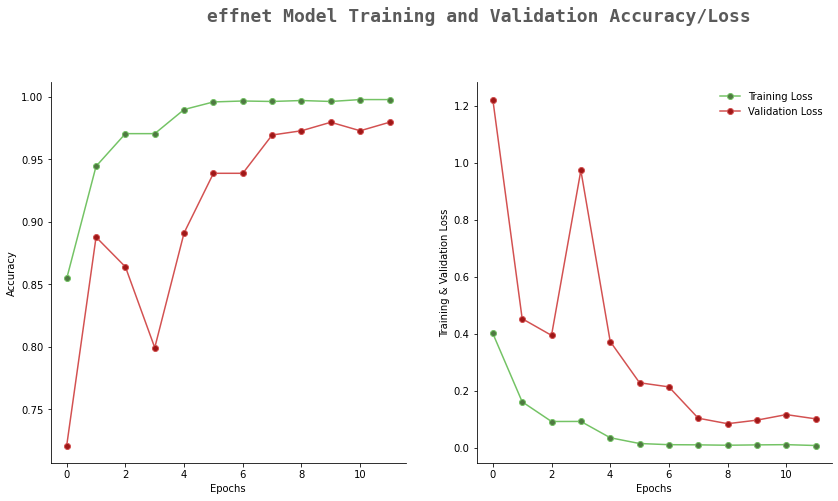

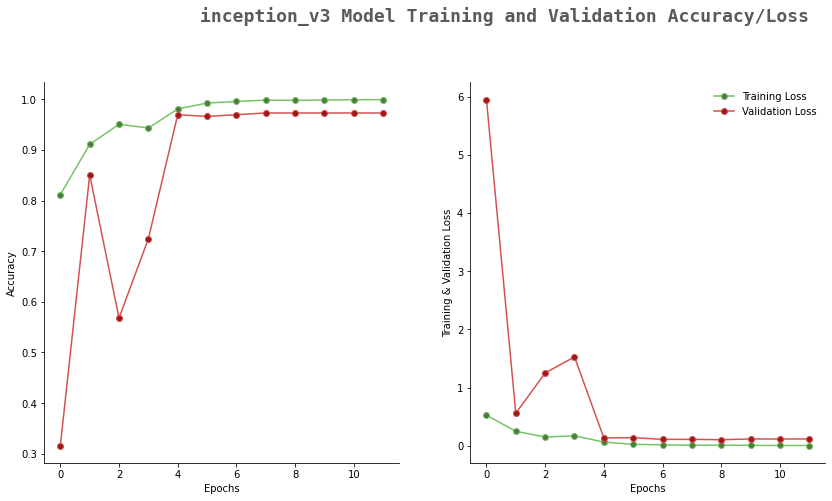

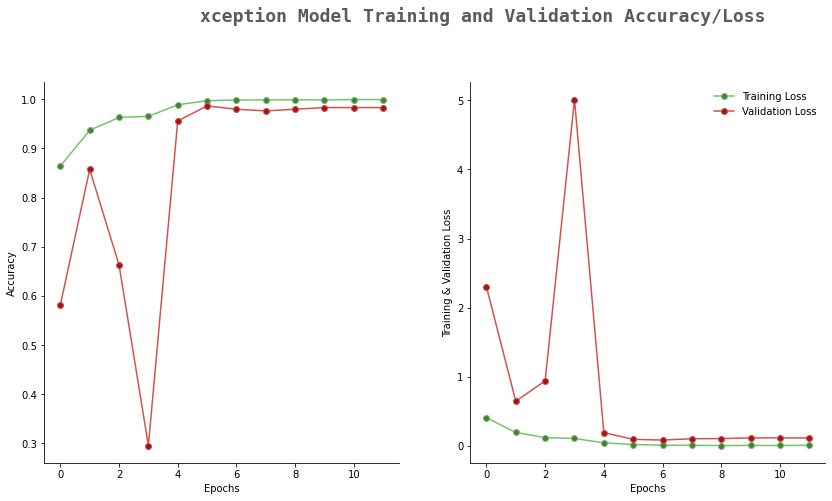

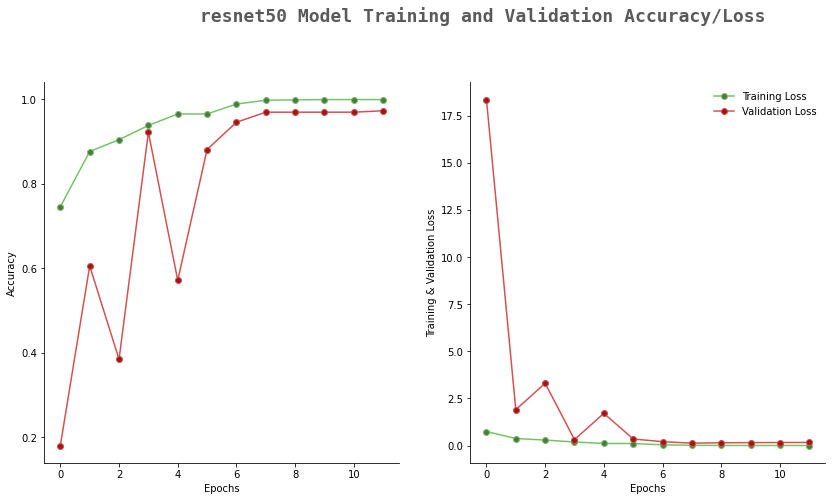

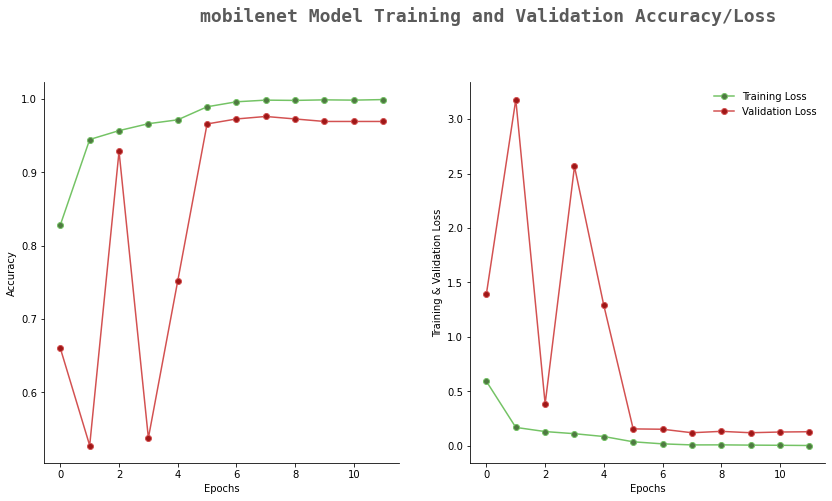

In [271]:
models = [effnet_model, inception_v3_model, xception_model, resnet50_model, mobilenet_model]
history = [effnet_history, inception_v3_history, xception_history, resnet50_history, mobilenet_history]
model_names = ["effnet","inception_v3","xception","resnet50","mobilenet"]
for i in range(5):
    plot_train_summary(history[i], model_names[i])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


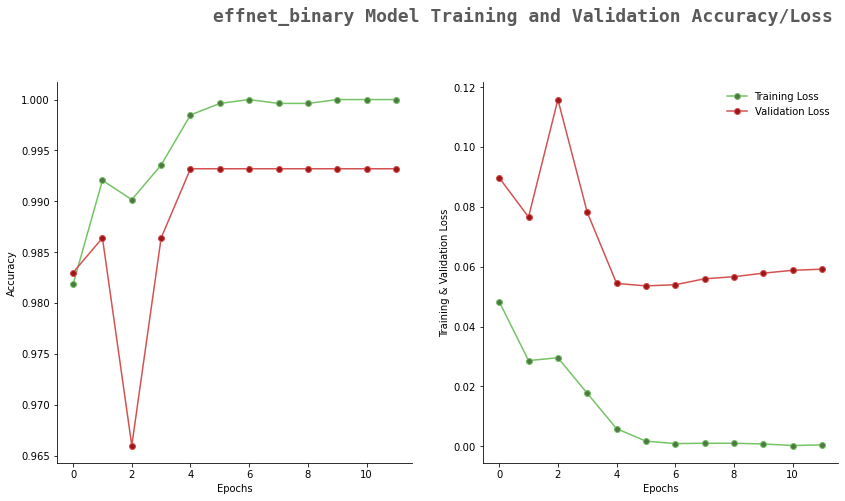

In [378]:
plot_train_summary(effnet_history_binary, "effnet_binary")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


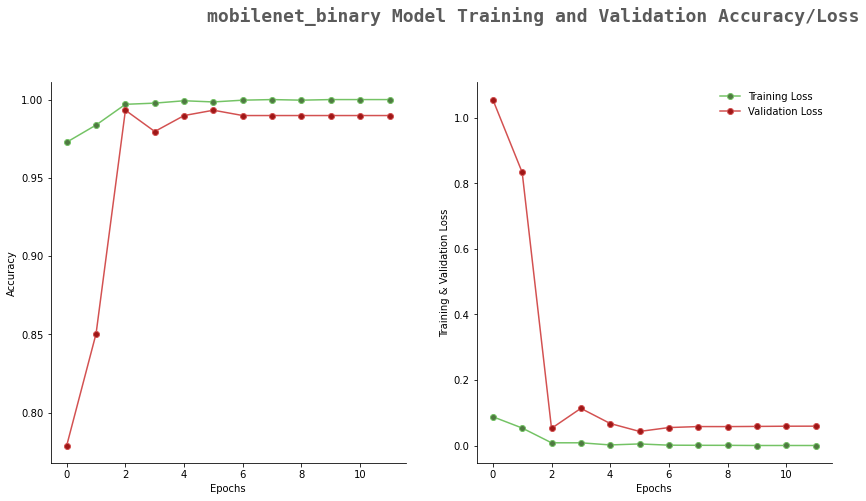

In [381]:
plot_train_summary(mobilenet_history_binary, "mobilenet_binary")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


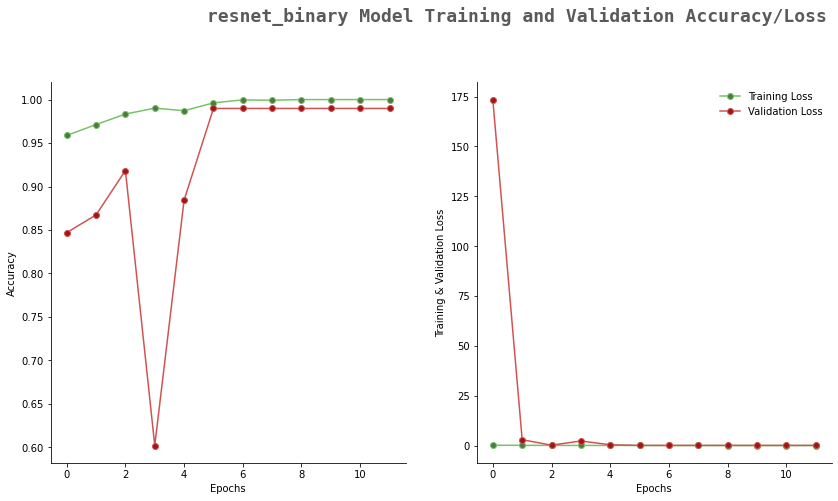

In [388]:
plot_train_summary(resnet50_history_binary, "resnet_binary")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


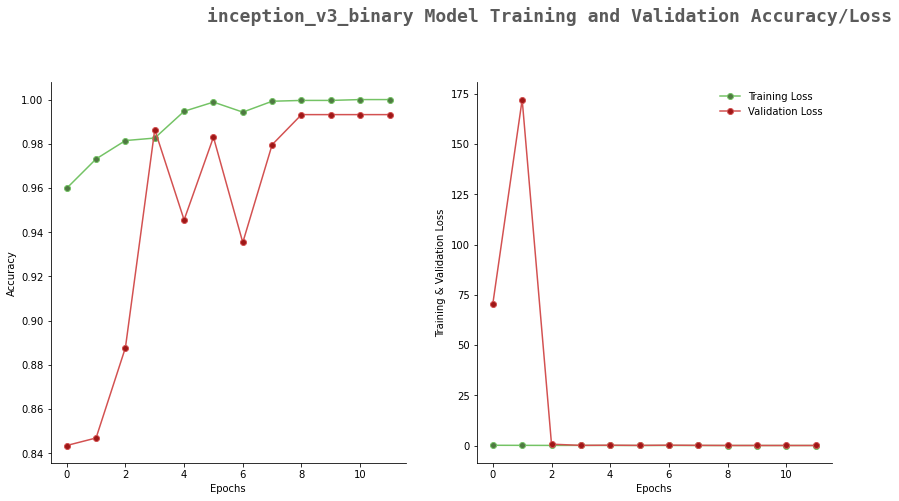

In [389]:
plot_train_summary(inception_v3_history_binary, "inception_v3_binary")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


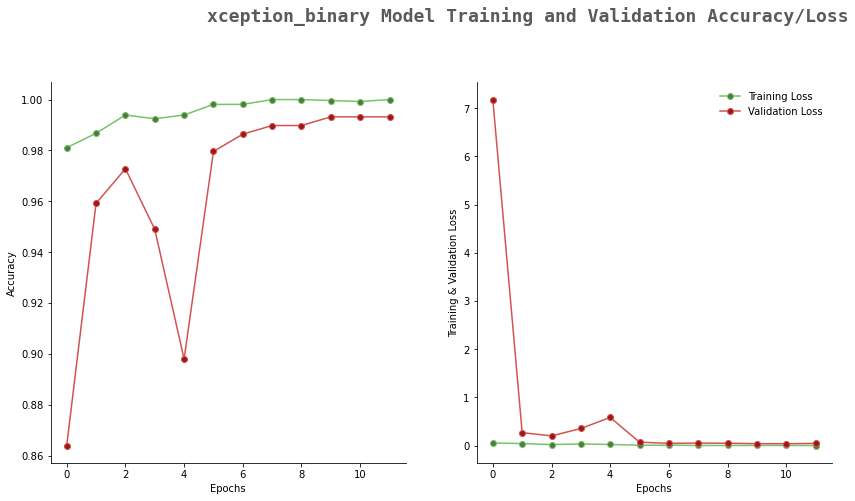

In [390]:
plot_train_summary(xception_history_binary, "xception_binary")

In [272]:
def make_prediction(model, X_test, y_test):
    pred = model.predict(X_test)
    pred = np.argmax(pred,axis=1)
    y_test_new = np.argmax(y_test,axis=1)
    print(classification_report(y_test_new,pred))
    return y_test_new
    

In [401]:
y_tests = []
model_names = ['effnet', 'inception_v3', 'xception', 'resnet50', 'mobilenet']
models = [effnet_model, inception_v3_model, xception_model, resnet50_model, mobilenet_model]
for i in range(5):
    print(model_names[i])
    y_tests.append(make_prediction(models[i], X_test, y_test))
    print()

effnet
              precision    recall  f1-score   support

           0       0.85      0.90      0.88        93
           1       1.00      1.00      1.00        51
           2       0.87      0.82      0.84        96
           3       0.97      0.95      0.96        87

    accuracy                           0.91       327
   macro avg       0.92      0.92      0.92       327
weighted avg       0.91      0.91      0.91       327


inception_v3
              precision    recall  f1-score   support

           0       0.47      0.67      0.55        93
           1       1.00      1.00      1.00        51
           2       0.52      0.32      0.40        96
           3       0.67      0.66      0.66        87

    accuracy                           0.61       327
   macro avg       0.67      0.66      0.65       327
weighted avg       0.62      0.61      0.61       327


xception
              precision    recall  f1-score   support

           0       0.84      0.72      0.77 

In [406]:
y_tests_binary = []
model_names_binary = ['effnet_binary', 'inception_v3_binary', 'xception_binary', 'resnet50_binary', 'mobilenet_binary']
models_binary = [effnet_model_binary, inception_v3_model_binary, xception_model_binary, resnet50_model_binary, mobilenet_model_binary]
for i in range(5):
    print(model_names_binary[i])
    y_tests_binary.append(make_prediction(models_binary[i], X_test_binary, y_test_binary))
    print()

effnet_binary
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       276
           1       1.00      0.98      0.99        51

    accuracy                           1.00       327
   macro avg       1.00      0.99      0.99       327
weighted avg       1.00      1.00      1.00       327


inception_v3_binary
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       276
           1       1.00      1.00      1.00        51

    accuracy                           1.00       327
   macro avg       1.00      1.00      1.00       327
weighted avg       1.00      1.00      1.00       327


xception_binary
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       276
           1       0.94      1.00      0.97        51

    accuracy                           0.99       327
   macro avg       0.97      0.99      0.98       327
weighted avg       0.9

In [275]:
def plot_confusion_matrix(y_test_new, model_name):
    fig,ax=plt.subplots(1,1,figsize=(14,7))
    sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
               cmap=['#DADADA', '#AEAEAE', '#636363', '#313131', '#1F1F1F'],alpha=0.7,linewidths=2,linecolor='#AEAEAE')
    fig.text(s=model_name+"'"+'s Heatmap of the Confusion Matrix',size=18,fontweight='bold',
                 fontname='monospace',color="#313131",y=0.92,x=0.28,alpha=0.8)

    plt.show()

In [408]:
def plot_confusion_matrix_binary(y_tests_binary, model_name):
    fig,ax=plt.subplots(1,1,figsize=(14,7))
    sns.heatmap(confusion_matrix(y_tests_binary,pred),ax=ax,xticklabels=labels_binary,yticklabels=labels_binary,annot=True,
               cmap=['#DADADA', '#AEAEAE', '#636363', '#313131', '#1F1F1F'],alpha=0.7,linewidths=2,linecolor='#AEAEAE')
    fig.text(s=model_name+"'"+'s Heatmap of the Confusion Matrix',size=18,fontweight='bold',
                 fontname='monospace',color="#313131",y=0.92,x=0.28,alpha=0.8)

    plt.show()

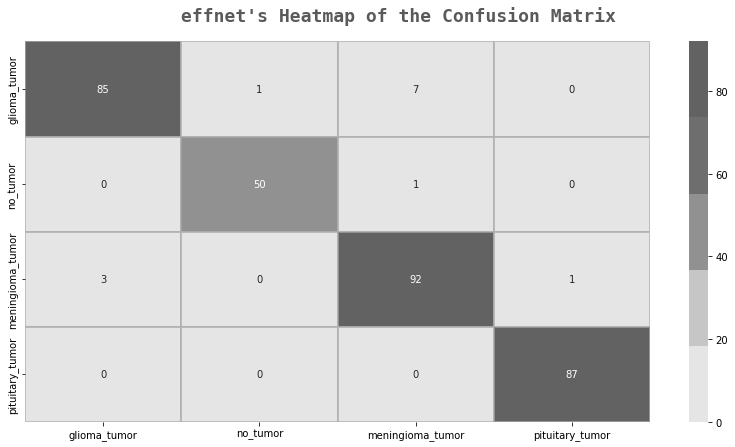

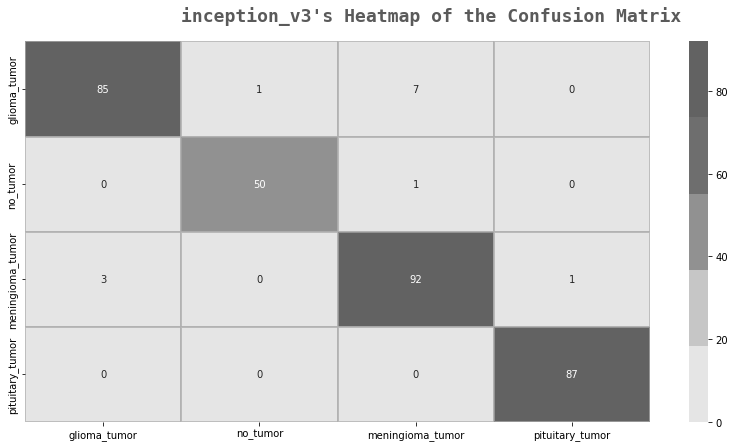

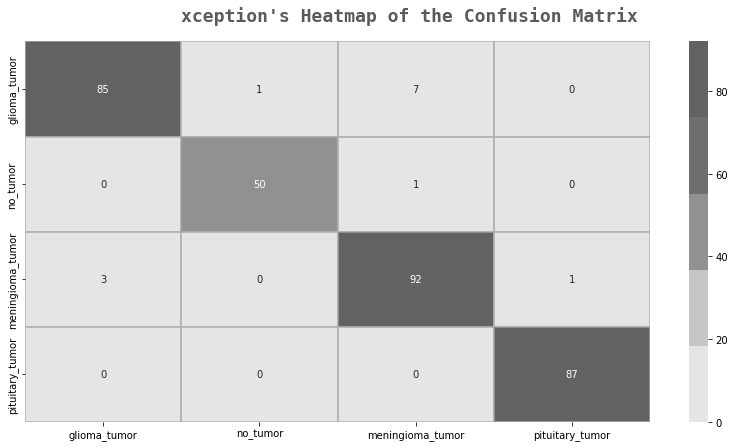

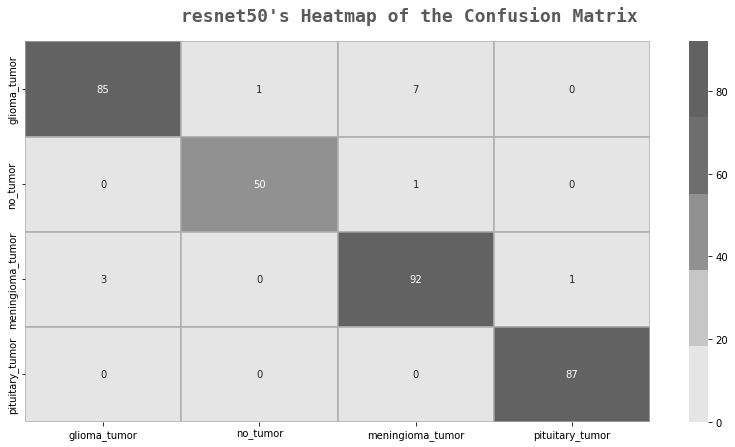

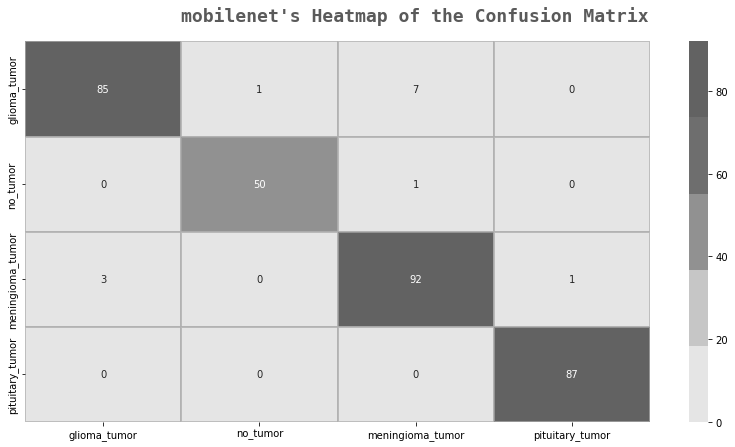

In [276]:
for i in range(5):
    plot_confusion_matrix(y_tests[i], model_names[i])
    print()